In [3]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline


In [4]:
dataset = MNIST(root='../data/', download=True, transform=ToTensor())

In [3]:
val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [4]:
batch_size =128

In [5]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [ ]:
for images, _ in train_loader:
    print('images.shape', images.shape)
    break

In [ ]:
for images, _ in train_loader:
    print('images.shape', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images,nrow=16).permute((1,2,0)))
    break 

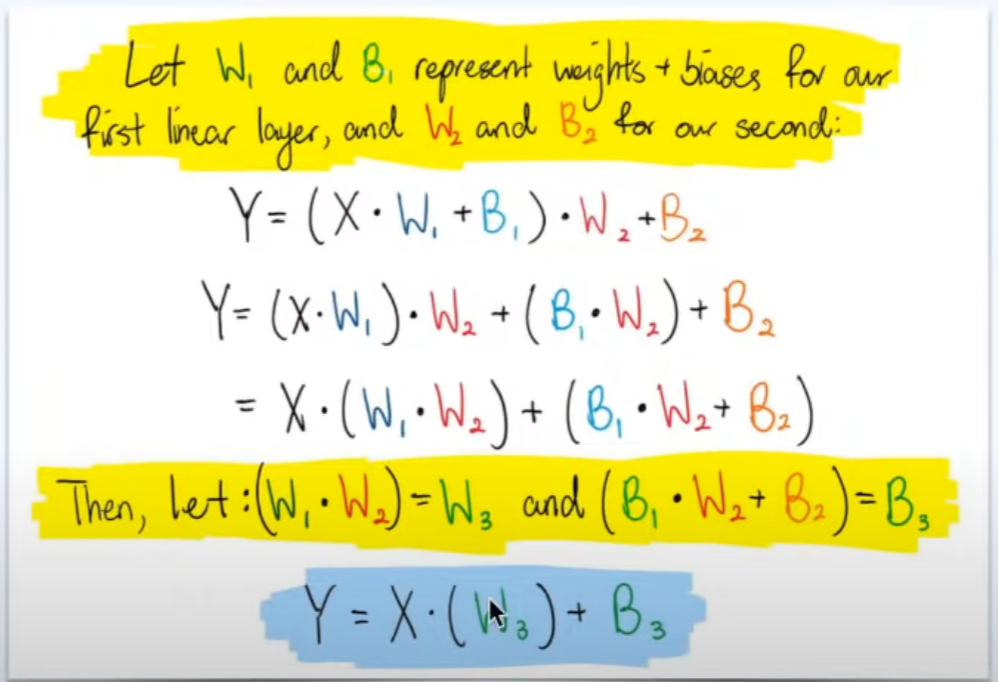

In [ ]:
# def model(xb):
#     return xb @ w.t() + b

# nn.Linear(in_size, out_size, ) 3 #tmp, humidyt sth /// 2 apples, oranges
# nn.Linear(in_size, out_size) # 28 x 28 in one vector, 10 values -> probability which number

## what if:
# nn.linear(28*28), 16)
# nn.linear(16, 10) -> czyli przepuszczamy to dwa razy, liczba 16 wyjeta lsoowa

# def forward():
#     out = self.linear1(xb)
#     out = self.liners2(out)
#     return out

#in outher words: 
#out = self.linear2(self.linear1(xb))
#out = (xb @ w1 + b) @ w2 + b2 = xb @ (w1 @ w2) + xb @ (b1 @ w1) + b2 = xb @ ((w1 @ w2) + (b1 @ w1)) + b2 = xb @ w3 + b2 = self.linear3() -> nic nie osiagnelismy czyli dwie warstwy to tyle samo co jedna



# def forward():
#     out = self.linear1(xb)
#     out = F.relu(out) <- activation function, non-linearity aka Rectified Linear Unit
#     out = self.liners2(out)
#     return out i wtedy to działa!


In [6]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [7]:
class MnistModel(nn.Module):
    """Feedforward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out) #sigmoid
        #Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        # Generate predictions
        out = self(images)
        # Calculate loss
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        # Generate predictions
        out = self(images)
        # Calculate loss
        loss = F.cross_entropy(out, labels)
        # Calculate accuracy
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        # Combine losses
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
     
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [8]:
input_size = 784
hidden_size = 784
num_classes = 10

model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [9]:
model

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
for t in model.parameters():
    print(t.shape)

In [ ]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape:', outputs.shape)
print('Sample outputs: \n', outputs[:2].data)


In [10]:
torch.cuda.is_available()

True

In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [12]:
device = get_default_device()
device

device(type='cuda')

In [13]:
def to_device(data, device):
    """Move tensor(s) to chose device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break;
          

In [14]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, service):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.data)

In [15]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [ ]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

In [16]:
def evaluate(mode, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [17]:
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=784, bias=True)
  (linear2): Linear(in_features=784, out_features=10, bias=True)
)

In [18]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3031866550445557, 'val_acc': 0.09042968600988388}]

In [19]:
# 1:36.7

#CPU 1:41.9
# Epoch [0], val_loss: 0.2419, val_acc: 0.9300
# Epoch [1], val_loss: 0.1730, val_acc: 0.9514
# Epoch [2], val_loss: 0.1505, val_acc: 0.9570
# Epoch [3], val_loss: 0.1448, val_acc: 0.9571
# Epoch [4], val_loss: 0.1348, val_acc: 0.9588

#GPU 1:37.8
# Epoch [0], val_loss: 0.2215, val_acc: 0.9339
# Epoch [1], val_loss: 0.1651, val_acc: 0.9518
# Epoch [2], val_loss: 0.1970, val_acc: 0.9374
# Epoch [3], val_loss: 0.1353, val_acc: 0.9608
# Epoch [4], val_loss: 0.1208, val_acc: 0.9640

history += fit(5, 0.5, model, train_loader, val_loader)


Epoch [0], val_loss: 0.1719, val_acc: 0.9508
Epoch [1], val_loss: 0.1596, val_acc: 0.9496
Epoch [2], val_loss: 0.1052, val_acc: 0.9668
Epoch [3], val_loss: 0.0896, val_acc: 0.9743
Epoch [4], val_loss: 0.0866, val_acc: 0.9725


In [19]:
history += fit(5, 0.1, model, train_loader, val_loader)
#0.9813 for RElu
#0.9420 for sigmoid

Epoch [0], val_loss: 0.2219, val_acc: 0.9369
Epoch [1], val_loss: 0.2177, val_acc: 0.9383
Epoch [2], val_loss: 0.2139, val_acc: 0.9399
Epoch [3], val_loss: 0.2113, val_acc: 0.9388
Epoch [4], val_loss: 0.2067, val_acc: 0.9420


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

In [ ]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy vs No. of epochs')